In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/all-products-available-on-sephora-website/sephora_website_dataset.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.model_selection import cross_val_score


In [3]:
# Import dataset
data = pd.read_csv('/kaggle/input/all-products-available-on-sephora-website/sephora_website_dataset.csv')


We did Exploratory Data Analysis (EDA) in the previous notebook : 
 
1. Load and examine the dataset
2. Check for missing values, outliers, and data inconsistencies
3. Explore the distribution of the target variable and other features
4. Perform data visualization to gain insights

## Feature Engineering

In [4]:
# Define the mapping from categories to broader categories
category_map = {
    'Makeup': ['Eye Palettes','Highlighter', 'Cheek Palettes', 'Lipstick',  'Face Primer',
               'Color Correct', 'Tinted Moisturizer',  'Concealer', 'BB & CC Cream',
               'Eyebrow', 'Mascara', 'Foundation','Setting Spray & Powder', 'Contour',
               'Eyeshadow', 'Lip Gloss',
       'False Eyelashes', 'Bronzer', 'Eyeliner', 'Eye Primer', 'Eye Sets', 'Eye Cream', 'Sunscreen',
       'Blush', 'Liquid Lipstick', 'Makeup','Face Sets', 'Lip Liner',  'Lip Stain', 'Lip Sets', 
              'Blotting Papers', 'Makeup Removers', 'Lip Plumper', 'For Face', 
               'BB & CC Creams','Makeup Palettes', 'Lip Treatments', 'Powder Brush', ],
    'Skincare': ['Lip Balm & Treatment', 'Lotions & Oils', 'Face Serums',
                   'Moisturizers', 'Eye Creams & Treatments','Face Sunscreen',
                 'Lip Balms & Treatments','Face Masks', 'Face Wash & Cleansers', 'Decollete & Neck Creams',
               'Face Oils','Facial Peels', 'Exfoliators','Face Wash', 
                'Toners', 'Sheet Masks','Skincare','Skincare Sets', 'Anti-Aging',
                'Eye Masks', 'Face Wipes', 'Night Creams', 'After Sun Care',
                 'Blemish & Acne Treatments',  'Lip Sunscreen'],
    
    
    'Body' : ['Body Lotions & Body Oils','Hand Cream & Foot Cream', 'Body Sunscreen',
             'Body Products',   'Moisturizer & Treatments', 'Bath & Shower', 
             'Scrub & Exfoliants','Cellulite & Stretch Marks','For Body', 'Self Tanners',
              'Body Wash & Shower Gel', 'Bath Soaks & Bubble Bath','Body Moisturizers','Bath & Body'
        ],
    'Haircare': ['Hair', 'Hair Styling & Treatments',
                 'Conditioner', 'Shampoo', 'Hair Styling Products',
                'Scalp & Hair Treatments', 'Hair Masks', 'Hair Spray', 'Hair Oil',
       'Hair Primers', 'Dry Shampoo', 'Hair', 'Hair Thinning & Hair Loss','Color Care',
                'Leave-In Conditioner', 'Hair Styling & Treatments', 'Shampoo & Conditioner','Hair Products'],
    
    'Fragrance': ['Fragrance', 'Cologne', 'Perfume', 'Body Mist & Hair Mist',
                 'Body Sprays & Deodorant','Perfume Gift Sets','Rollerballs & Travel Size','Mists & Essences', 
                 'Deodorant & Antiperspirant','Deodorant for Men'],
    
    'Tools & Brushes': [ 'Hair Straighteners & Flat Irons', 'Hair Dryers',  'Curling Irons',
                        'Eye Brushes', 'Tweezers & Eyebrow Tools','Face Brushes',
                        'Sponges & Applicators', 'Mirrors & Sharpeners', 
                        'Brush Sets','Brush Cleaners', 'Lip Brushes',
                       'Facial Rollers','Hair Brushes & Combs',
                        'Facial Cleansing Brushes', 'Cleansing Brushes',  'Lid Shadow Brush',
        'Curls & Coils',  'Eyelash Curlers','High Tech Tools','Spa Tools'],
    
    'Misc':['no category', 'Hair Accessories',
                 'Candles & Home Scents', 'Beauty Supplements', 'Makeup & Travel Cases', 'Holistic Wellness',
                  'Accessories','Candles',  'Nail', 'Makeup Bags & Travel Cases',
                  'Teeth Whitening',  'Diffusers',  'Wellness',
                 ],
    'Giftsets' : ['Perfume Gift Sets', 'Value & Gift Sets','Cologne Gift Sets'],
    'Mini Size' :['Mini Size',],
    'Shaving' : ['Hair Removal', 'Hair Removal & Shaving','Aftershave', 'Shaving']
}

# Create a new column that maps each category to a broader group
data['category_group'] = 'other'
for group, categories in category_map.items():
    mask = data['category'].isin(categories)
    data.loc[mask, 'category_group'] = group


In [5]:
data.head()

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer,category_group
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,...,online only,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0,Fragrance
1,2044816,Acqua Di Parma,Cologne,Colonia,0.7 oz/ 20 mL,4.5,76,2700,66.0,66.0,...,online only,- 0.7 oz/ 20 mL Spray - 1.7 oz/ 50 mL Eau d...,An elegant timeless scent filled with a fresh-...,no instructions,unknown,1,0,0,0,Fragrance
2,1417567,Acqua Di Parma,Perfume,Arancia di Capri,5 oz/ 148 mL,4.5,26,2600,180.0,180.0,...,online only,- 1oz/30mL Eau de Toilette - 2.5 oz/ 74 mL E...,Fragrance Family: Fresh Scent Type: Fresh Citr...,no instructions,Alcohol Denat.- Water- Fragrance- Limonene- Li...,1,0,0,0,Fragrance
3,1417617,Acqua Di Parma,Perfume,Mirto di Panarea,2.5 oz/ 74 mL,4.5,23,2900,120.0,120.0,...,online only,- 1 oz/ 30 mL Eau de Toilette Spray - 2.5 oz/...,Panarea near Sicily is an an island suspended ...,no instructions,unknown,1,0,0,0,Fragrance
4,2218766,Acqua Di Parma,Fragrance,Colonia Miniature Set,5 x 0.16oz/5mL,3.5,2,943,72.0,80.0,...,online only,no options,The Colonia Miniature Set comes in an iconic A...,Suggested Usage:-Fragrance is intensified by t...,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,1,0,0,0,Fragrance


* category_subcategory: combines the "category" and "sub_category" columns into a single feature.
* name_length: represents the length of the "name" column.
* description_word_count: represents the total number of words in the "description" column.
* description_avg_word_length: represents the average word length in the "description" column.
* online_exclusive: represents whether or not the product has both "online_only" and "exclusive" flags.


In [6]:
data['MarketingFlags'].unique()

array([ True, False])

In [7]:
# Create a new feature that represents the length of the "name" column
data['name_length'] = data['name'].apply(lambda x: len(x))

# Create a new feature that represents the total number of words in the "description" column
data['description_word_count'] = data['details'].apply(lambda x: len(x.split()))

# Create a new feature that represents the average word length in the "description" column
data['description_avg_word_length'] = data['details'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))

# Create a new feature that represents whether or not the product has both "online_only" and "exclusive" flags
data['online_exclusive'] = (data['online_only'] == 1) & (data['exclusive'] == 1)

# Create a new feature which shows if 'how to use' is available or not
data['usage'] = data['how_to_use'].apply(lambda x : 0 if x == 'no instructions' else 1 )

# Create a new feature which shows if 'ingreadient list' is available or not
data['ingredient_available'] = data['ingredients'].apply(lambda x : 0 if x == 'unknown' else 1 )

# Create a new column 'SephoraVRest' with 1 for 'Sephora Brand' and 0 for any other brand
data['SephoraVRest'] = data['brand'].apply(lambda x: 1 if x == 'SEPHORA COLLECTION' else 0)

data['MarketingFlags'] = data['MarketingFlags'].astype(int)



# Drop the original columns that were used to create the new features
#data.drop(['category', 'sub_category', 'name', 'description', 'online_only', 'exclusive'], axis=1, inplace=True)

## Data Preprocessing

In [8]:
data['transformed_number_of_reviews'] = np.log(data['number_of_reviews'])
data['transformed_love'] = np.log(data['love'])
data['transformed_price'] = np.log(data['price'])
data['transformed_value_price'] = np.log(data['value_price'])

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
data.isna().sum()

id                               0
brand                            0
category                         0
name                             0
size                             0
rating                           0
number_of_reviews                0
love                             0
price                            0
value_price                      0
URL                              0
MarketingFlags                   0
MarketingFlags_content           0
options                          0
details                          0
how_to_use                       0
ingredients                      0
online_only                      0
exclusive                        0
limited_edition                  0
limited_time_offer               0
category_group                   0
name_length                      0
description_word_count           0
description_avg_word_length      0
online_exclusive                 0
usage                            0
ingredient_available             0
SephoraVRest        

In [10]:
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
print(numeric_cols)

Index(['id', 'rating', 'number_of_reviews', 'love', 'price', 'value_price',
       'MarketingFlags', 'online_only', 'exclusive', 'limited_edition',
       'limited_time_offer', 'name_length', 'description_word_count',
       'description_avg_word_length', 'usage', 'ingredient_available',
       'SephoraVRest', 'transformed_number_of_reviews', 'transformed_love',
       'transformed_price', 'transformed_value_price'],
      dtype='object')


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
data.columns

Index(['id', 'brand', 'category', 'name', 'size', 'rating',
       'number_of_reviews', 'love', 'price', 'value_price', 'URL',
       'MarketingFlags', 'MarketingFlags_content', 'options', 'details',
       'how_to_use', 'ingredients', 'online_only', 'exclusive',
       'limited_edition', 'limited_time_offer', 'category_group',
       'name_length', 'description_word_count', 'description_avg_word_length',
       'online_exclusive', 'usage', 'ingredient_available', 'SephoraVRest',
       'transformed_number_of_reviews', 'transformed_love',
       'transformed_price', 'transformed_value_price'],
      dtype='object')

In [13]:
features = [
       'id', 
       'number_of_reviews', 'love', 'price', 'value_price', 
       'MarketingFlags',  'online_only', 'exclusive',
       'limited_edition', 'limited_time_offer', 'category_group',
       'name_length', 'description_word_count', 'description_avg_word_length',
       'online_exclusive', 'usage', 'ingredient_available', 'SephoraVRest',
       #'transformed_number_of_reviews', 'transformed_love','transformed_price', 'transformed_value_price'
            
           ]
target = ['rating']

X = data[features]
y = data['rating']

In [14]:
# Split the dataset into training and testing sets with 80/20 split and stratification on y
X_train_init, X_holdout, y_train_init, y_holdout = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
X_train_init.columns

Index(['id', 'number_of_reviews', 'love', 'price', 'value_price',
       'MarketingFlags', 'online_only', 'exclusive', 'limited_edition',
       'limited_time_offer', 'category_group', 'name_length',
       'description_word_count', 'description_avg_word_length',
       'online_exclusive', 'usage', 'ingredient_available', 'SephoraVRest'],
      dtype='object')

In [16]:
print(X_train_init.shape, X_holdout.shape, X.shape)

(7334, 18) (1834, 18) (9168, 18)


In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class PassThroughTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features=None):
        self.features = features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.features is None:
            return X
        else:
            return X.drop(self.features, axis=1)
        
pass_thru_feat = ['MarketingFlags', 'online_only', 'exclusive', 'limited_edition',
       'limited_time_offer', 'category_group', 'name_length',
       'description_word_count', 'description_avg_word_length',
       'online_exclusive', 'usage', 'ingredient_available', 'SephoraVRest']

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

# columns to standardize
numeric_features = ['number_of_reviews', 'love', 'price', 'value_price']

# columns to one hot encode
categorical_features = ['category_group']

# define preprocessing steps for numerical data
numeric_log_transformer = Pipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# create the preprocessing pipelines for the categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])




# combine the numerical and categorical preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('passthru', PassThroughTransformer(pass_thru_feat), pass_thru_feat)
    ])

preprocessor_log = ColumnTransformer(
    transformers=[
        ('num', numeric_log_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

preprocessor_log_extra_feat = ColumnTransformer(
    transformers=[
        ('num', numeric_log_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('passthru', PassThroughTransformer(pass_thru_feat), pass_thru_feat)
    ])



In [19]:
# define the models to be evaluated
models = [('Linear Regression', LinearRegression()),
          ('Ridge Regression', Ridge(alpha=1.0)),
          ('Lasso Regression', Lasso(alpha=1.0)),
          ('ElasticNet Regression', ElasticNet(alpha=1.0)),
          ('Random Forest Regression', RandomForestRegressor(n_estimators=100)),
          ('Support Vector Regression', SVR(kernel='linear')),
          ('XGBoost Regression', XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))]


# define the evaluation metrics
metrics = {'MSE': mean_squared_error,
           'MAE': mean_absolute_error,
           'MSLE': mean_squared_log_error,
           'R2': r2_score}

In [20]:
k_folds = 5

# create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Model', 'Metric', 'Score'])
results_df_holdout = pd.DataFrame(columns=['Model', 'Metric', 'Score'])

# loop over each model and perform k-fold cross-validation
for name, model in models:
    #print(name)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor_log_extra_feat),
                               ('model', model)])
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    for metric_name, metric_func in metrics.items():
        #print(metric_name)
        scores = []
        for train_index, test_index in kf.split(X_train_init):
            X_train, X_test = X_train_init.iloc[train_index], X_train_init.iloc[test_index]
            y_train, y_test = y_train_init.iloc[train_index], y_train_init.iloc[test_index]
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            if (name == "XGBoost Regression") & (metric_name == "MSLE"):
                y_pred = np.clip(y_pred, 0, 5)
            score = metric_func(y_test, y_pred)
            scores.append(score)
        mean_score = np.mean(scores)
        eval_dict = {'Model': name, 'Metric': metric_name, 'Score': mean_score}
        results_df = results_df.append(eval_dict, ignore_index=True)
        
        # predict on the holdout set
        y_pred = pipeline.predict(X_holdout)
        y_pred = np.clip(y_pred, 0, 5)
        score = metric_func(y_holdout, y_pred)
        eval_dict = {'Model': name, 'Metric': metric_name, 'Score': score}
        results_df_holdout = results_df_holdout.append(eval_dict, ignore_index=True)
        
    
   
        
    

Based on the evaluation metrics provided, it appears that the Random Forest Regression model has the best performance. It has the lowest MSE and MSLE, highest R2 score, and a relatively low MAE. 

In [21]:
results_df 

,Model,Metric,Score
0,Linear Regression,MSE,0.847143
1,Linear Regression,MAE,0.610151
2,Linear Regression,MSLE,0.106260
3,Linear Regression,R2,0.165120
4,Ridge Regression,MSE,0.847101
5,Ridge Regression,MAE,0.610132
6,Ridge Regression,MSLE,0.106263
7,Ridge Regression,R2,0.165158
8,Lasso Regression,MSE,1.014965
9,Lasso Regression,MAE,0.590460


In [22]:
results_df_holdout

,Model,Metric,Score
0,Linear Regression,MSE,0.843194
1,Linear Regression,MAE,0.615156
2,Linear Regression,MSLE,0.105627
3,Linear Regression,R2,0.171053
4,Ridge Regression,MSE,0.843238
5,Ridge Regression,MAE,0.615149
6,Ridge Regression,MSLE,0.105637
7,Ridge Regression,R2,0.171010
8,Lasso Regression,MSE,1.017200
9,Lasso Regression,MAE,0.589691


In [23]:
k_folds = 5

# create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Model', 'Metric', 'Score'])
results_df_holdout = pd.DataFrame(columns=['Model', 'Metric', 'Score'])

# loop over each model and perform k-fold cross-validation
for name, model in models:
    #print(name)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor_log),
                               ('model', model)])
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    for metric_name, metric_func in metrics.items():
        #print(metric_name)
        scores = []
        for train_index, test_index in kf.split(X_train_init):
            X_train, X_test = X_train_init.iloc[train_index], X_train_init.iloc[test_index]
            y_train, y_test = y_train_init.iloc[train_index], y_train_init.iloc[test_index]
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            if (name == "XGBoost Regression") & (metric_name == "MSLE"):
                y_pred = np.clip(y_pred, 0, 5)
            score = metric_func(y_test, y_pred)
            scores.append(score)
        mean_score = np.mean(scores)
        eval_dict = {'Model': name, 'Metric': metric_name, 'Score': mean_score}
        results_df = results_df.append(eval_dict, ignore_index=True)
        
        # predict on the holdout set
        y_pred = pipeline.predict(X_holdout)
        y_pred = np.clip(y_pred, 0, 5)
        score = metric_func(y_holdout, y_pred)
        eval_dict = {'Model': name, 'Metric': metric_name, 'Score': score}
        results_df_holdout = results_df_holdout.append(eval_dict, ignore_index=True)  

In [24]:
results_df

,Model,Metric,Score
0,Linear Regression,MSE,0.847143
1,Linear Regression,MAE,0.610151
2,Linear Regression,MSLE,0.106260
3,Linear Regression,R2,0.165120
4,Ridge Regression,MSE,0.847101
5,Ridge Regression,MAE,0.610132
6,Ridge Regression,MSLE,0.106263
7,Ridge Regression,R2,0.165158
8,Lasso Regression,MSE,1.014965
9,Lasso Regression,MAE,0.590460


It looks like the results with additional features did not significantly improve the performance of the models. The R2 scores for the Random Forest and XGBoost regressions have decreased slightly, while the other metrics have not shown any significant improvement. Lets stick to model with lesser features.

Based on the results on the holdout set, we can see that the Random Forest Regression model performed the best, with the lowest MSE score of 0.303139 and the highest R2 score of 0.700702. This suggests that the Random Forest model is the best fit for our data and is able to explain a significant amount of the variance in the target variable.

On the other hand, the linear models such as Linear Regression, Ridge Regression, Lasso Regression, and ElasticNet Regression did not perform as well as the other models, with relatively high MSE and MSLE scores and low R2 scores. This suggests that a linear relationship between the features and the target variable may not be the best fit for our data.

The Support Vector Regression model also did not perform as well as the Random Forest model, with a relatively high MSE score of 0.952224 and a low R2 score of 0.063866.

It's important to note that these results are based on a single holdout set and may not necessarily generalize well to new, unseen data. Therefore, it's important to evaluate the models on multiple holdout sets or perform cross-validation to get a better estimate of their performance.

I'll perform cross-validation on entire set and see if the results are consistent with the holdout set evaluation

In [25]:
k_folds = 5

# create an empty dataframe to store the results
results_df_entire_set = pd.DataFrame(columns=['Model', 'Metric', 'Score'])


# loop over each model and perform k-fold cross-validation
for name, model in models:
    #print(name)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor_log),
                               ('model', model)])
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    for metric_name, metric_func in metrics.items():
        #print(metric_name)
        scores = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            if (name == "XGBoost Regression") & (metric_name == "MSLE"):
                y_pred = np.clip(y_pred, 0, 5)
            score = metric_func(y_test, y_pred)
            scores.append(score)
        mean_score = np.mean(scores)
        eval_dict = {'Model': name, 'Metric': metric_name, 'Score': mean_score}
        results_df_entire_set = results_df_entire_set.append(eval_dict, ignore_index=True)   

In [26]:
results_df_entire_set

,Model,Metric,Score
0,Linear Regression,MSE,0.848171
1,Linear Regression,MAE,0.611228
2,Linear Regression,MSLE,0.106302
3,Linear Regression,R2,0.164656
4,Ridge Regression,MSE,0.848144
5,Ridge Regression,MAE,0.611207
6,Ridge Regression,MSLE,0.106305
7,Ridge Regression,R2,0.164683
8,Lasso Regression,MSE,1.015408
9,Lasso Regression,MAE,0.590735


The performance metrics are generally consistent. For most models, the difference in scores between holdout set and cross-validation is not significant, suggesting that the models are not overfitting to the training set.

The best performing model in terms of MSE and R2 in both holdout set evaluation and cross-validation is the Random Forest Regression model, which has a low MSE and high R2 score, indicating a good balance between accuracy and generalizability.

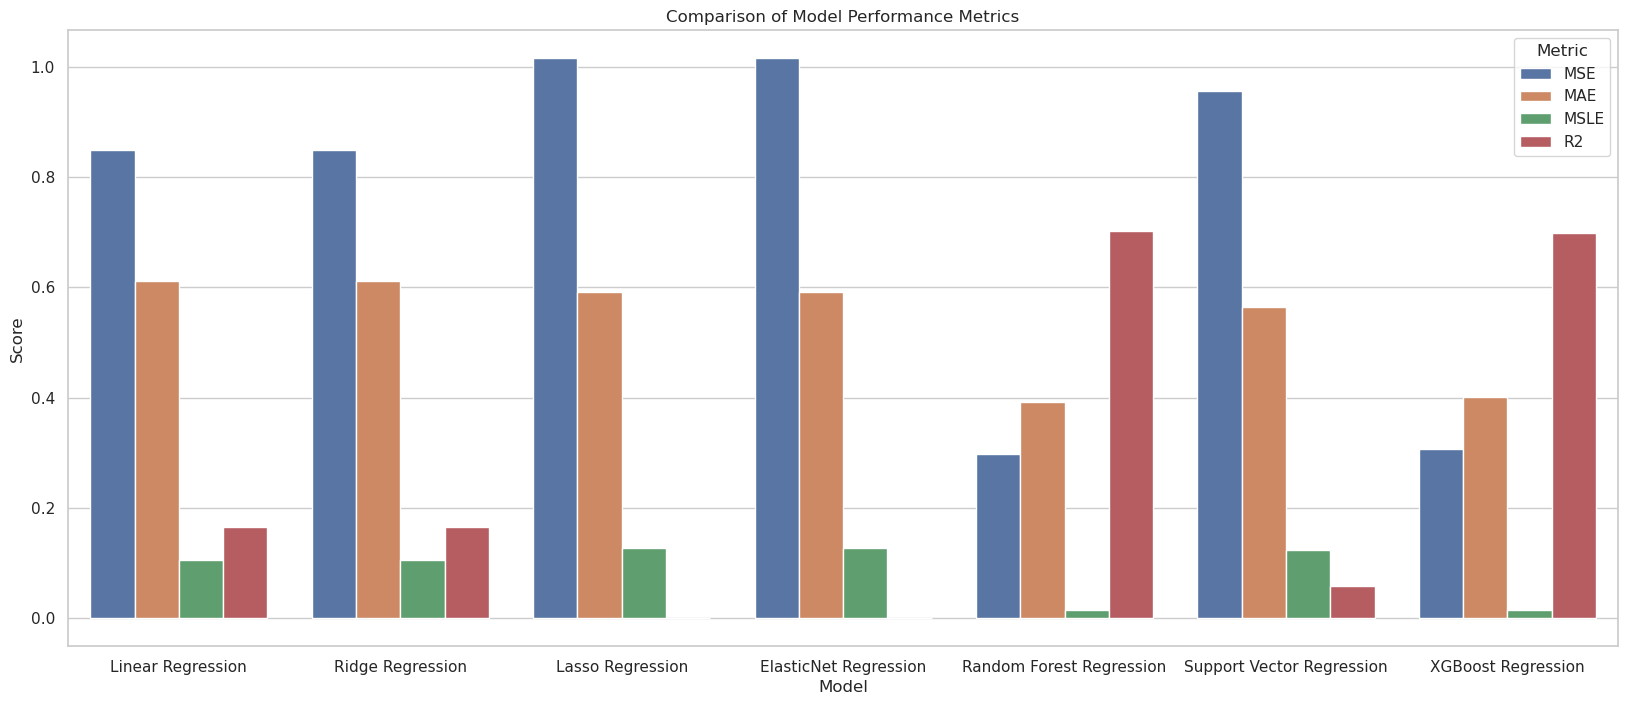

In [27]:
# plot the scores using seaborn
sns.set(style='whitegrid')

plt.figure(figsize=(20, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_df_entire_set)
# Set the x-ticks and angle them
# plt.xticks(results_df_entire_set.index, results_df_entire_set.Model, rotation=45)
# plt.locator_params(axis='x', nbins=40)

plt.title('Comparison of Model Performance Metrics')
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()

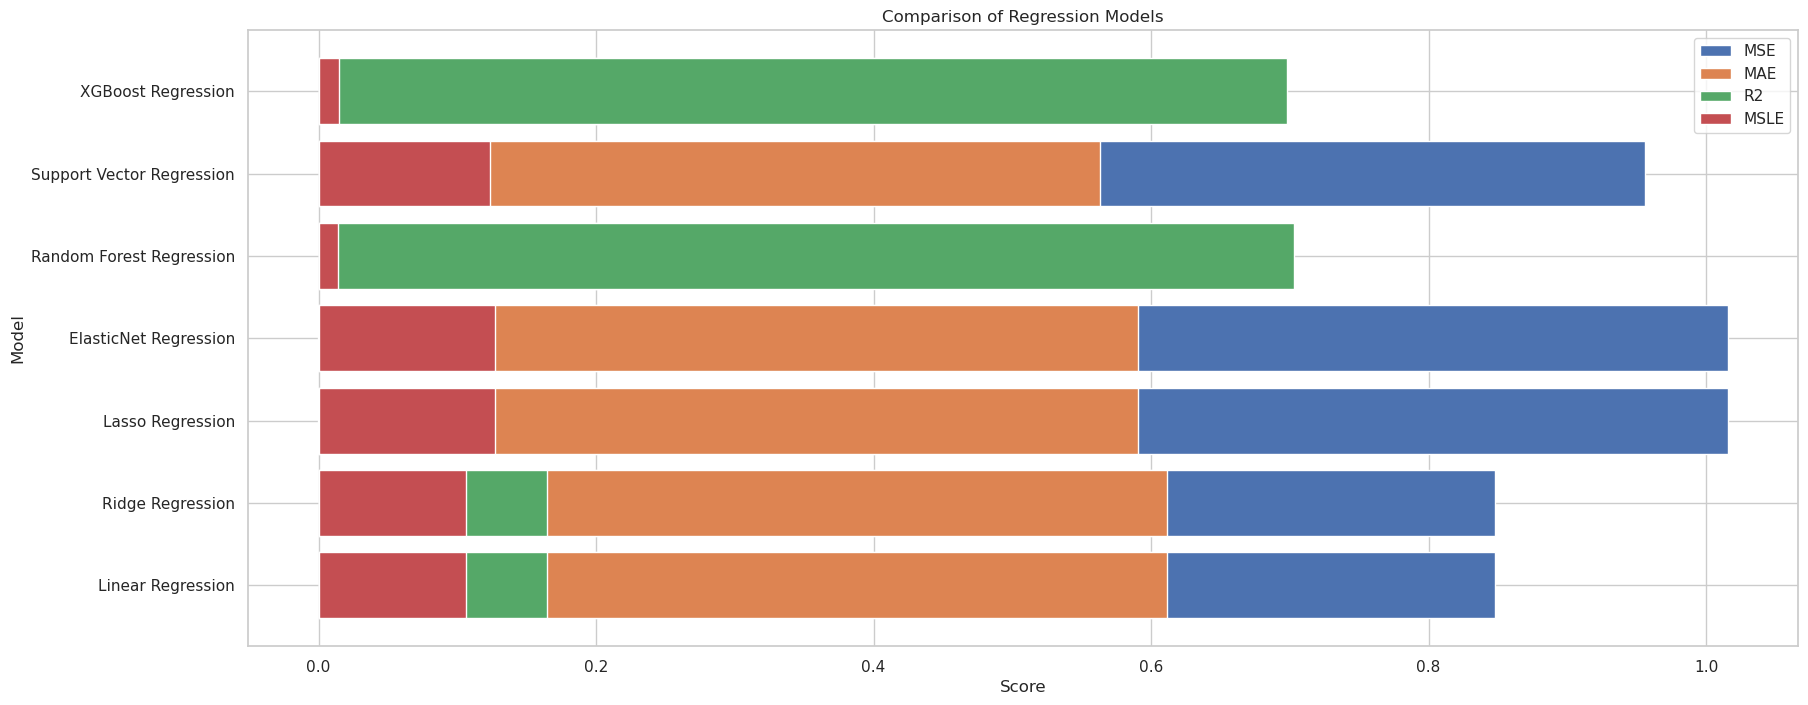

In [28]:
# Extract the data for each metric
mse_scores = results_df_entire_set[results_df_entire_set['Metric'] == 'MSE']['Score']
mae_scores = results_df_entire_set[results_df_entire_set['Metric'] == 'MAE']['Score']
msle_scores = results_df_entire_set[results_df_entire_set['Metric'] == 'MSLE']['Score']
r2_scores = results_df_entire_set[results_df_entire_set['Metric'] == 'R2']['Score']

# Create a list of labels for each model
model_labels = results_df_entire_set['Model'].unique()

# Set the figure size
plt.figure(figsize=(20, 8))

# Plot the bars for each metric

plt.barh(model_labels, mse_scores, label='MSE')
plt.barh(model_labels, mae_scores, label='MAE')
plt.barh(model_labels, r2_scores, label='R2')
plt.barh(model_labels, msle_scores, label='MSLE')



# Add titles and labels
plt.title('Comparison of Regression Models')
plt.xlabel('Score')
plt.ylabel('Model')

# Add a legend
plt.legend()

# Show the plot
plt.show()

Since Random Forest is the best performing model. Let's explore it. 

In [29]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor_log),
                               ('model', RandomForestRegressor(n_estimators=100))])

pipeline.fit(X_train_init, y_train_init)
y_pred = pipeline.predict(X_holdout)

#calculate mse mae r2 msle
mse = mean_squared_error(y_holdout, y_pred)
mae = mean_absolute_error(y_holdout, y_pred)
r2 = r2_score(y_holdout, y_pred)
msle = mean_squared_log_error(y_holdout, y_pred)

# print the evaluation metrics
print('MSE:', mse)
print('MAE:', mae)
print('R2:', r2)
print('MSLE:', msle)

MSE: 0.3054979286433721
MAE: 0.3933992639040349
R2: 0.6996639306849843
MSLE: 0.014459400410900986


In [30]:
# Get feature importance for all encoded columns
importances = pipeline.named_steps['model'].feature_importances_

# get the transformed feature names
feature_names = preprocessor_log.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features)

feature_names = numeric_features + list(feature_names)
print(feature_names)

['number_of_reviews', 'love', 'price', 'value_price', 'category_group_Body', 'category_group_Fragrance', 'category_group_Giftsets', 'category_group_Haircare', 'category_group_Makeup', 'category_group_Mini Size', 'category_group_Misc', 'category_group_Shaving', 'category_group_Skincare', 'category_group_Tools & Brushes']


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


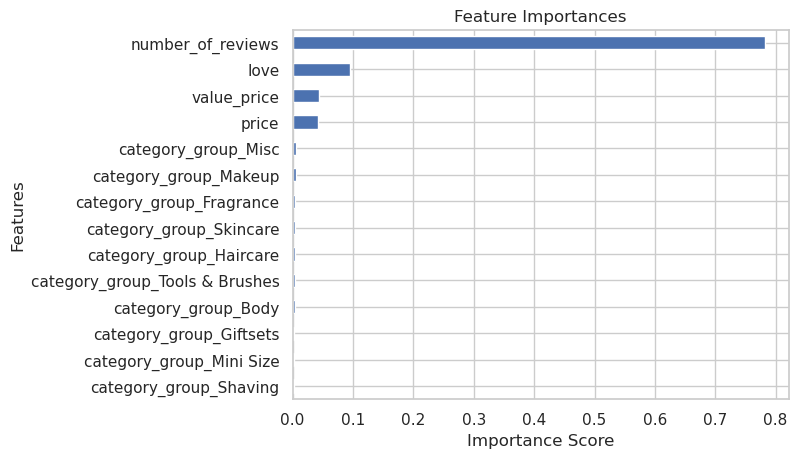

In [34]:
feature_importances = pd.Series(importances, index=feature_names)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

* The feature importance values indicate that number_of_reviews is the most important feature for predicting product ratings in the Sephora dataset. This could be because the number of reviews is often an indicator of product popularity and how many people have used the product, which can impact the overall rating. For example, a product with many reviews may have a higher rating because it is more widely used and has been tested by more people, whereas a new product with few reviews may have a lower rating simply because it hasn't been tried by many people yet. 

* Additionally, the number of reviews could also be an indicator of product quality, as a high number of reviews can help to identify any potential issues or areas for improvement with the product.

## Conclusion

Based on the feature importances, the number of reviews is the most important feature in predicting the rating of a product on Sephora's website, with an importance score of 0.782401. Other important features include the "love" score (0.094248), the value price (0.043810), and the regular price (0.041388). The category of the product also plays a role, with the most important categories being skincare, fragrance, makeup, and miscellaneous items. Overall, these findings suggest that customer reviews are the most important factor in predicting the rating of a product on Sephora, followed by the price and category of the product.